In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rules = pd.read_csv("all-rules-with-metrics.csv").sort_values(by=["fromLib", "ruleFreq"], ascending=[True, False])

rules = rules[rules["fromLib"] != rules["toLib"]]
rules["relativeRuleFrequency"] = 0
rules["concurrenceAdjustment"] = 0
rules["popularityRegularization"] = 0
rules["apiSupport"] = 0
rules["distanceAdjustment"] = rules["distance"].apply(lambda x: np.mean([((5 + 1) / (int(y) + 1)) ** 1 for y in x.split(";")]))
for from_lib, rows in rules.groupby(by="fromLib"):
    relativeRuleFreq = rows["ruleFreq"] / max(rows["ruleFreq"])
    apiSupport = rows["apiCounter"] / max(rows["apiCounter"])
    concurrenceAdjustment = rows["ruleFreq"] / rows["concurrence"]
    popularityRegularization = relativeRuleFreq * concurrenceAdjustment
    rules["relativeRuleFrequency"].update(relativeRuleFreq)
    rules["concurrenceAdjustment"].update(concurrenceAdjustment)
    rules["popularityRegularization"].update(popularityRegularization)
    rules["apiSupport"].update(apiSupport)
    
possible_rules = rules[rules["isPossible"]]
confirmed_rules = rules[rules["isConfirmed"]]
other_rules = rules[(~rules["isPossible"]) & (~rules["isConfirmed"])]
print("# possible rules = {}, # confirmed rules = {}, # other rules = {}".format(
      len(possible_rules), 
      len(confirmed_rules), 
      len(other_rules)
))

# possible rules = 1511, # confirmed rules = 289, # other rules = 651798


In [3]:
rules.to_csv("all-rules-with-metrics.csv", index=False)

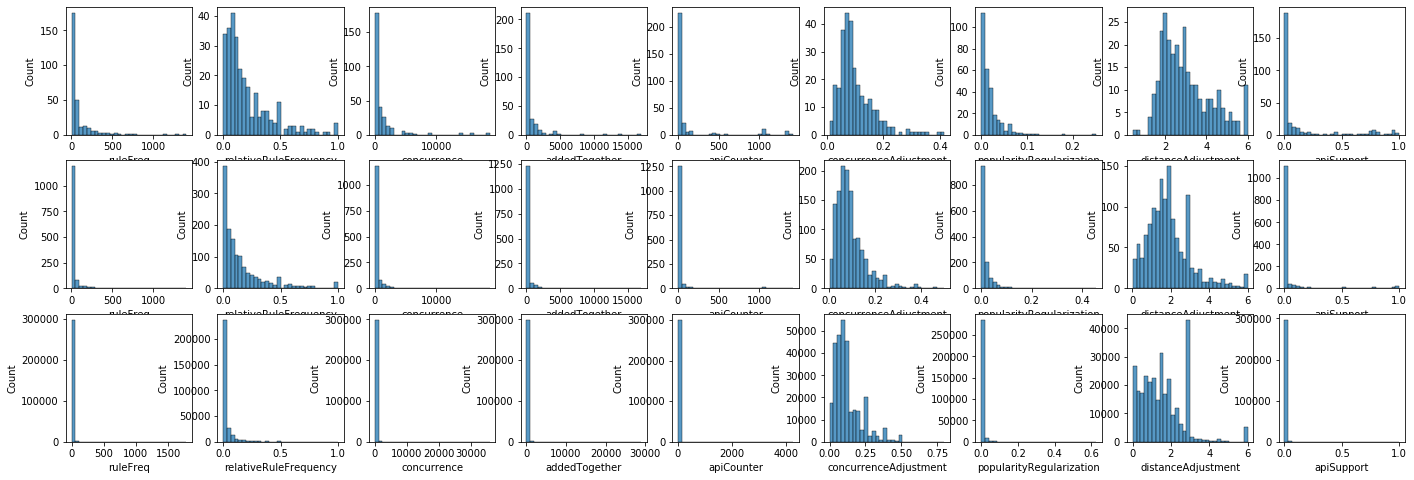

In [16]:
data = [
    rules[rules["isConfirmed"] & (rules["concurrence"] >= 10)], 
    rules[rules["isPossible"] & (rules["concurrence"] >= 8)], 
    rules[(~rules["isPossible"]) & (~rules["isConfirmed"]) & (rules["concurrence"] >= 8)]
]
axis = [
    "ruleFreq", "relativeRuleFrequency", "concurrence", 
    "addedTogether", "apiCounter", "concurrenceAdjustment",
    "popularityRegularization", "distanceAdjustment", "apiSupport"
]
fig, axes = plt.subplots(3, len(axis), figsize=(24, 8))
for i in range(0, 3):
    for j in range(0, len(axis)):
        sns.histplot(data=data[i], x=axis[j], ax=axes[i][j], bins=30)
plt.show()

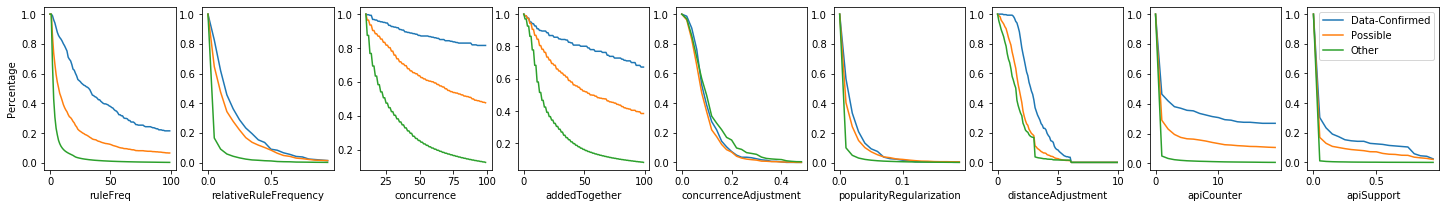

In [26]:
def get_dist(metric, min_val, max_val, interval):
    possible_vals = []
    confirmed_vals = []
    other_vals = []
    for i in np.arange(min_val, max_val, interval):
        possible_vals.append(len(possible_rules[(possible_rules[metric] >= i) & (possible_rules["concurrence"] >= 10)]) / len(possible_rules[(possible_rules["concurrence"] >= 10)]))
        confirmed_vals.append(len(confirmed_rules[(confirmed_rules[metric] >= i) & (confirmed_rules["concurrence"] >= 10)]) / len(confirmed_rules[(confirmed_rules["concurrence"] >= 10)]))
        other_vals.append(len(other_rules[(other_rules[metric] >= i) & (other_rules["concurrence"] >= 10)]) / len(other_rules[(other_rules["concurrence"] >= 10)]))
    return possible_vals, confirmed_vals, other_vals
params = [
    ("ruleFreq", 0, 100, 1), 
    ("relativeRuleFrequency", 0, 1.0, 0.05), 
    ("concurrence", 10, 100, 1), 
    ("addedTogether", 0, 100, 1),
    ("concurrenceAdjustment", 0, 0.5, 0.02),
    ("popularityRegularization", 0, 0.2, 0.01),
    ("distanceAdjustment", 0, 10, 0.1),
    ("apiCounter", 0, 20, 1), 
    ("apiSupport", 0, 1, 0.05)
]
fig, axes = plt.subplots(1, len(params), figsize=(25, 3))
for i, param in enumerate(params):
    possible, confirmed, other = get_dist(*param)
    x = list(np.arange(param[1], param[2], param[3]))
    axes[i].plot(x, confirmed, label="Data-Confirmed")
    axes[i].plot(x, possible, label="Possible")
    axes[i].plot(x, other, label="Other")
    axes[i].set_xlabel(param[0])
    if i == 0:
        axes[i].set_ylabel("Percentage")
    if i == len(params) - 1:
        axes[i].legend()
fig.show()

In [6]:
def show_dist(metric, min_val, max_val, interval):
    for i in np.arange(min_val, max_val, interval):
        print("{} > {:.2f}: # possible = {}({:.2%}), # confirmed = {}({:.2%}), # other = {}({:.2%})".format(
            metric, i,
            len(possible_rules[possible_rules[metric] >= i]),
            len(possible_rules[possible_rules[metric] >= i]) / len(possible_rules),
            len(confirmed_rules[confirmed_rules[metric] >= i]),
            len(confirmed_rules[confirmed_rules[metric] >= i]) / len(confirmed_rules),
            len(other_rules[other_rules[metric] >= i]),
            len(other_rules[other_rules[metric] >= i]) / len(other_rules),
        ))
show_dist("ruleFreq", 0, 30, 1)

ruleFreq > 0.00: # possible = 1511(100.00%), # confirmed = 289(100.00%), # other = 651798(100.00%)
ruleFreq > 1.00: # possible = 1511(100.00%), # confirmed = 289(100.00%), # other = 651798(100.00%)
ruleFreq > 2.00: # possible = 1152(76.24%), # confirmed = 284(98.27%), # other = 230894(35.42%)
ruleFreq > 3.00: # possible = 973(64.39%), # confirmed = 276(95.50%), # other = 118731(18.22%)
ruleFreq > 4.00: # possible = 868(57.45%), # confirmed = 270(93.43%), # other = 79747(12.23%)
ruleFreq > 5.00: # possible = 777(51.42%), # confirmed = 261(90.31%), # other = 59010(9.05%)
ruleFreq > 6.00: # possible = 710(46.99%), # confirmed = 252(87.20%), # other = 47834(7.34%)
ruleFreq > 7.00: # possible = 662(43.81%), # confirmed = 246(85.12%), # other = 38531(5.91%)
ruleFreq > 8.00: # possible = 611(40.44%), # confirmed = 242(83.74%), # other = 32804(5.03%)
ruleFreq > 9.00: # possible = 581(38.45%), # confirmed = 239(82.70%), # other = 28624(4.39%)
ruleFreq > 10.00: # possible = 548(36.27%), # confir

In [7]:
show_dist("relativeRuleFrequency", 0, 1.0, 0.05)

relativeRuleFrequency > 0.00: # possible = 1511(100.00%), # confirmed = 289(100.00%), # other = 651798(100.00%)
relativeRuleFrequency > 0.05: # possible = 954(63.14%), # confirmed = 239(82.70%), # other = 77418(11.88%)
relativeRuleFrequency > 0.10: # possible = 706(46.72%), # confirmed = 180(62.28%), # other = 43360(6.65%)
relativeRuleFrequency > 0.15: # possible = 513(33.95%), # confirmed = 133(46.02%), # other = 26276(4.03%)
relativeRuleFrequency > 0.20: # possible = 419(27.73%), # confirmed = 106(36.68%), # other = 19325(2.96%)
relativeRuleFrequency > 0.25: # possible = 334(22.10%), # confirmed = 84(29.07%), # other = 14870(2.28%)
relativeRuleFrequency > 0.30: # possible = 261(17.27%), # confirmed = 68(23.53%), # other = 10608(1.63%)
relativeRuleFrequency > 0.35: # possible = 213(14.10%), # confirmed = 57(19.72%), # other = 7438(1.14%)
relativeRuleFrequency > 0.40: # possible = 188(12.44%), # confirmed = 45(15.57%), # other = 6847(1.05%)
relativeRuleFrequency > 0.45: # possible = 16

In [8]:
show_dist("concurrence", 0, 20, 1)

concurrence > 0.00: # possible = 1511(100.00%), # confirmed = 289(100.00%), # other = 651798(100.00%)
concurrence > 1.00: # possible = 1511(100.00%), # confirmed = 289(100.00%), # other = 651798(100.00%)
concurrence > 2.00: # possible = 1511(100.00%), # confirmed = 289(100.00%), # other = 651798(100.00%)
concurrence > 3.00: # possible = 1459(96.56%), # confirmed = 288(99.65%), # other = 484514(74.33%)
concurrence > 4.00: # possible = 1459(96.56%), # confirmed = 288(99.65%), # other = 484514(74.33%)
concurrence > 5.00: # possible = 1393(92.19%), # confirmed = 288(99.65%), # other = 364654(55.95%)
concurrence > 6.00: # possible = 1393(92.19%), # confirmed = 288(99.65%), # other = 364654(55.95%)
concurrence > 7.00: # possible = 1357(89.81%), # confirmed = 287(99.31%), # other = 300097(46.04%)
concurrence > 8.00: # possible = 1357(89.81%), # confirmed = 287(99.31%), # other = 300097(46.04%)
concurrence > 9.00: # possible = 1306(86.43%), # confirmed = 287(99.31%), # other = 252272(38.70%)
c

In [9]:
show_dist("addedTogether", 0, 20, 1)

addedTogether > 0.00: # possible = 1511(100.00%), # confirmed = 289(100.00%), # other = 651798(100.00%)
addedTogether > 1.00: # possible = 1441(95.37%), # confirmed = 285(98.62%), # other = 477643(73.28%)
addedTogether > 2.00: # possible = 1441(95.37%), # confirmed = 285(98.62%), # other = 477643(73.28%)
addedTogether > 3.00: # possible = 1354(89.61%), # confirmed = 281(97.23%), # other = 343430(52.69%)
addedTogether > 4.00: # possible = 1354(89.61%), # confirmed = 281(97.23%), # other = 343430(52.69%)
addedTogether > 5.00: # possible = 1271(84.12%), # confirmed = 273(94.46%), # other = 255171(39.15%)
addedTogether > 6.00: # possible = 1271(84.12%), # confirmed = 273(94.46%), # other = 255171(39.15%)
addedTogether > 7.00: # possible = 1201(79.48%), # confirmed = 270(93.43%), # other = 206061(31.61%)
addedTogether > 8.00: # possible = 1201(79.48%), # confirmed = 270(93.43%), # other = 206061(31.61%)
addedTogether > 9.00: # possible = 1139(75.38%), # confirmed = 266(92.04%), # other = 17

In [10]:
show_dist("apiCounter", 0, 20, 1)

apiCounter > 0.00: # possible = 1511(100.00%), # confirmed = 289(100.00%), # other = 651798(100.00%)
apiCounter > 1.00: # possible = 407(26.94%), # confirmed = 133(46.02%), # other = 15770(2.42%)
apiCounter > 2.00: # possible = 325(21.51%), # confirmed = 120(41.52%), # other = 10583(1.62%)
apiCounter > 3.00: # possible = 274(18.13%), # confirmed = 109(37.72%), # other = 8018(1.23%)
apiCounter > 4.00: # possible = 246(16.28%), # confirmed = 106(36.68%), # other = 6659(1.02%)
apiCounter > 5.00: # possible = 233(15.42%), # confirmed = 102(35.29%), # other = 5708(0.88%)
apiCounter > 6.00: # possible = 230(15.22%), # confirmed = 101(34.95%), # other = 5145(0.79%)
apiCounter > 7.00: # possible = 221(14.63%), # confirmed = 96(33.22%), # other = 4652(0.71%)
apiCounter > 8.00: # possible = 211(13.96%), # confirmed = 93(32.18%), # other = 4345(0.67%)
apiCounter > 9.00: # possible = 199(13.17%), # confirmed = 90(31.14%), # other = 3956(0.61%)
apiCounter > 10.00: # possible = 189(12.51%), # confir

In [11]:
show_dist("popularityRegularization", 0, 1, 0.05)

popularityRegularization > 0.00: # possible = 1511(100.00%), # confirmed = 289(100.00%), # other = 651798(100.00%)
popularityRegularization > 0.05: # possible = 158(10.46%), # confirmed = 28(9.69%), # other = 17197(2.64%)
popularityRegularization > 0.10: # possible = 67(4.43%), # confirmed = 6(2.08%), # other = 6686(1.03%)
popularityRegularization > 0.15: # possible = 31(2.05%), # confirmed = 3(1.04%), # other = 2838(0.44%)
popularityRegularization > 0.20: # possible = 23(1.52%), # confirmed = 2(0.69%), # other = 2012(0.31%)
popularityRegularization > 0.25: # possible = 17(1.13%), # confirmed = 2(0.69%), # other = 1546(0.24%)
popularityRegularization > 0.30: # possible = 4(0.26%), # confirmed = 1(0.35%), # other = 705(0.11%)
popularityRegularization > 0.35: # possible = 4(0.26%), # confirmed = 1(0.35%), # other = 489(0.08%)
popularityRegularization > 0.40: # possible = 3(0.20%), # confirmed = 1(0.35%), # other = 419(0.06%)
popularityRegularization > 0.45: # possible = 3(0.20%), # confi

In [12]:
show_dist("distanceAdjustment", 0, 3, 0.1)

distanceAdjustment > 0.00: # possible = 1511(100.00%), # confirmed = 289(100.00%), # other = 651798(100.00%)
distanceAdjustment > 0.10: # possible = 1495(98.94%), # confirmed = 289(100.00%), # other = 610035(93.59%)
distanceAdjustment > 0.20: # possible = 1478(97.82%), # confirmed = 289(100.00%), # other = 570443(87.52%)
distanceAdjustment > 0.30: # possible = 1439(95.23%), # confirmed = 288(99.65%), # other = 534621(82.02%)
distanceAdjustment > 0.40: # possible = 1420(93.98%), # confirmed = 288(99.65%), # other = 509583(78.18%)
distanceAdjustment > 0.50: # possible = 1390(91.99%), # confirmed = 287(99.31%), # other = 489440(75.09%)
distanceAdjustment > 0.60: # possible = 1356(89.74%), # confirmed = 287(99.31%), # other = 458842(70.40%)
distanceAdjustment > 0.70: # possible = 1336(88.42%), # confirmed = 287(99.31%), # other = 442406(67.87%)
distanceAdjustment > 0.80: # possible = 1289(85.31%), # confirmed = 286(98.96%), # other = 416566(63.91%)
distanceAdjustment > 0.90: # possible = 1

In [13]:
show_dist("apiSupport", 0, 1, 0.05)

apiSupport > 0.00: # possible = 1511(100.00%), # confirmed = 289(100.00%), # other = 651798(100.00%)
apiSupport > 0.05: # possible = 242(16.02%), # confirmed = 87(30.10%), # other = 3958(0.61%)
apiSupport > 0.10: # possible = 188(12.44%), # confirmed = 67(23.18%), # other = 2646(0.41%)
apiSupport > 0.15: # possible = 159(10.52%), # confirmed = 55(19.03%), # other = 1985(0.30%)
apiSupport > 0.20: # possible = 145(9.60%), # confirmed = 50(17.30%), # other = 1616(0.25%)
apiSupport > 0.25: # possible = 134(8.87%), # confirmed = 44(15.22%), # other = 1414(0.22%)
apiSupport > 0.30: # possible = 125(8.27%), # confirmed = 42(14.53%), # other = 1167(0.18%)
apiSupport > 0.35: # possible = 120(7.94%), # confirmed = 41(14.19%), # other = 1024(0.16%)
apiSupport > 0.40: # possible = 115(7.61%), # confirmed = 41(14.19%), # other = 938(0.14%)
apiSupport > 0.45: # possible = 105(6.95%), # confirmed = 37(12.80%), # other = 825(0.13%)
apiSupport > 0.50: # possible = 104(6.88%), # confirmed = 36(12.46%), 